In [3]:
import os, glob, re, numpy as np, geopandas as gpd, rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

SHAPEFILE = "../data/raw/city boundaries/citygcs_regional_mun_wgs84.shp" 
NDVI_GLOB = "../data/raw/modis-terra vegetation indices/nvdi/MOD13Q1.061__250m_16days_NDVI_2024-*.tif"
QA_GLOB   = "../data/raw/modis-terra vegetation indices/vi quality/MOD13Q1.061__250m_16_days_VI_Quality_2024-*.tif"
OUT_DIR   = "../data/processed/ndvi_clean"

os.makedirs(OUT_DIR, exist_ok = True)
OUT_SINU  = os.path.join(OUT_DIR, "ndvi_summer_2024_mean_sinusoidal.tif")
OUT_WGS84 = os.path.join(OUT_DIR, "ndvi_summer_2024_mean_wgs84.tif")
OUT_VALID = os.path.join(OUT_DIR, "ndvi_summer_2024_valid_count.tif")

date_re = re.compile(r"(\d{4}-\d{2}-\d{2})")

def sort_by_date(file_list):
    matches = {}
    for file_path in sorted(glob.glob(file_list)):
        match = date_re.search(file_path)
        if match:
            matches[match.group(1)] = file_path
    return matches

ndvi_by_date = sort_by_date(NDVI_GLOB)
qa_by_date   = sort_by_date(QA_GLOB)

if not ndvi_by_date:
    raise FileNotFoundError("No NDVI files found.")
if not qa_by_date:
    print("⚠️ No VI Quality files found; proceeding without QA masking.")

dates = sorted(ndvi_by_date.keys())
pairs = [(date, ndvi_by_date[date], qa_by_date.get(date)) for date in dates]

missing_qa = [date for date, _, qa in pairs if qa is None]
if missing_qa:
    print("⚠️ Missing QA for dates:", missing_qa)

with rasterio.open(pairs[0][1]) as src0:
    r_crs = src0.crs
city = gpd.read_file(SHAPEFILE).to_crs(r_crs) # reprojecting shapefile to sinusoidal grid

def soft_quality_mask(qa_arr):
    bits01 = qa_arr & 0b11
    return (bits01 == 0) | (bits01 == 1) # useable iff. qa flag is 00 or 01



C:\Users\vedan\AppData\Local\Temp\ipykernel_31032\3177739745.py:33: RuntimeWarning: Mean of empty slice
  summer_mean = np.nanmean(stack, axis = 0)


✅ Saved: ../data/processed/ndvi_clean\ndvi_summer_2024_mean_sinusoidal.tif
✅ Saved: ../data/processed/ndvi_clean\ndvi_summer_2024_valid_count.tif (per-pixel # of valid dates)
🌍 Saved: ../data/processed/ndvi_clean\ndvi_summer_2024_mean_wgs84.tif


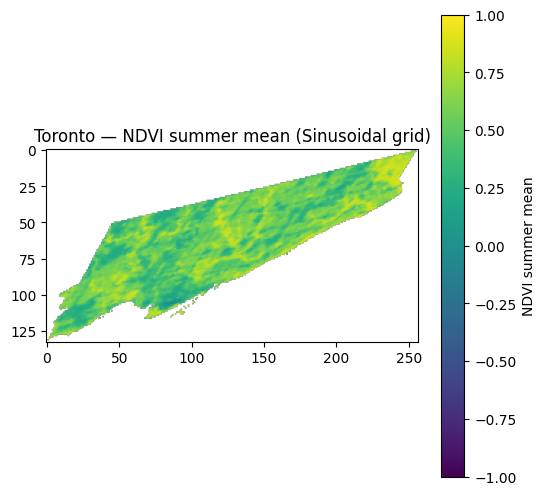

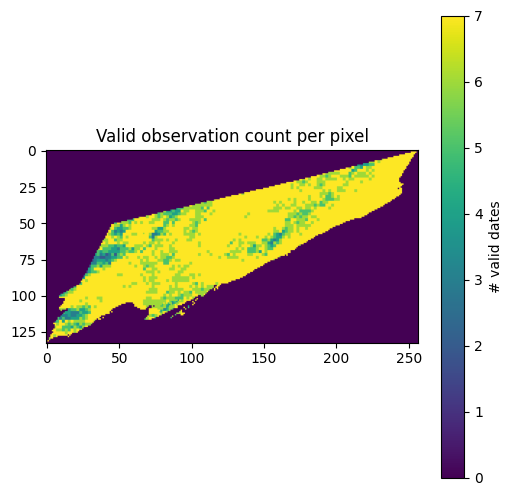

Coverage stats: 
  mean valid obs/pixel: 2.29 
  % pixels with ≥1 obs: 34.9% 
  % pixels with ≥3 obs: 34.8%


In [4]:
stack = []
valid_count = None
transform_ref = None
meta_ref = None

for dates, ndvi_fp, qa_fp in pairs:
    with rasterio.open(ndvi_fp) as src:
        ndvi_clip, ndvi_transform = mask(src, city.geometry, crop = True, nodata = src.nodata)
        ndvi = ndvi_clip[0].astype("float32")

        # Treat common MODIS fills as NaN; keep negative NDVI (water/urban) as valid readings
        ndvi[(ndvi == -3000) | (ndvi == -28672)] = np.nan
        ndvi *= 0.0001

        # Determine data quality using VI quality data
        if qa_fp:
            with rasterio.open(qa_fp) as qsrc:
                qa_clip, _ = mask(qsrc, city.geometry, crop=True, nodata=qsrc.nodata)
                qa = qa_clip[0].astype("uint16")
                good = soft_quality_mask(qa)
                ndvi = np.where(good, ndvi, np.nan)

        stack.append(ndvi)

        vc = np.isfinite(ndvi).astype("uint16")
        valid_count = vc if valid_count is None else (valid_count + vc)

        if transform_ref is None:
            transform_ref = ndvi_transform
            meta_ref = src.meta.copy()

stack = np.array(stack)                 
summer_mean = np.nanmean(stack, axis = 0)
summer_mean = summer_mean.astype("float32")

# save sindusoidal data (science-grade outputs)
meta_out = meta_ref.copy()
meta_out.update({
    "height": summer_mean.shape[0],
    "width":  summer_mean.shape[1],
    "transform": transform_ref,
    "dtype": "float32",
    "count": 1,
    "crs": r_crs,
    "nodata": np.nan,
})
with rasterio.open(OUT_SINU, "w", **meta_out) as dst:
    dst.write(summer_mean, 1)

meta_vc = meta_out.copy()
meta_vc.update({"dtype": "uint16", "nodata": 0})
with rasterio.open(OUT_VALID, "w", **meta_vc) as dst:
    dst.write(valid_count, 1)

print(f"✅ Saved: {OUT_SINU}")
print(f"✅ Saved: {OUT_VALID} (per-pixel # of valid dates)")

# Build copy in WGS84 projection for mapping
with rasterio.open(OUT_SINU) as src:
    dst_crs = "EPSG:4326"
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    meta_wgs = src.meta.copy()
    meta_wgs.update({
        "crs": dst_crs, "transform": transform,
        "width": width, "height": height,
        "dtype": "float32", "nodata": np.nan
    })
    with rasterio.open(OUT_WGS84, "w", **meta_wgs) as dst:
        reproject(
            source = rasterio.band(src, 1),
            destination = rasterio.band(dst, 1),
            src_transform = src.transform, src_crs = src.crs,
            dst_transform = transform,  dst_crs = dst_crs,
            resampling = Resampling.bilinear
        )
print(f"🌍 Saved: {OUT_WGS84}")

# sanity check - show plots
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(summer_mean, vmin = -1, vmax = 1)
plt.colorbar(im, ax = ax, label = "NDVI summer mean")
ax.set_title("Toronto — NDVI summer mean (Sinusoidal grid)")
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(valid_count)
plt.colorbar(im, ax = ax, label = "# valid dates")
ax.set_title("Valid observation count per pixel")
plt.show()

print("Coverage stats:",
      f"\n  mean valid obs/pixel: {np.nanmean(valid_count):.2f}",
      f"\n  % pixels with ≥1 obs: {100 * np.mean(valid_count >= 1):.1f}%",
      f"\n  % pixels with ≥3 obs: {100 * np.mean(valid_count >= 3):.1f}%")
